# Job Fiction - Indexing Jobs Data to Build a Training Model

## Objective

Objective of this notebook is to build a training model based on JOBFICTION database, a collection of job posts, job titles, company, location, job post URL acquired from Indeed Web Services API. Using the training model, we will be able to predict right job title based on the job descriptions passed to the model. Output from the training model would include - a corpus based on vector space model, key words and phrases, skill identifiers, predicted job titles and corresponding scores. All the results will be persisted and updated with the new jobs being collected.

Based on the input from job seekers i.e. job descriptions submitted we will able to determine 

- Job titles closest to the job description or keywords submitted (based on the weights associated)
- Recommended job posts
- Keywords to search for the right job posts

The first part of this notebook will explore how jobs in the JOBFICTION database can be classified. 

**Why do we have to classify the job posts?**

A `truck driver` job post is way different from a `database administrator` job post. With the help of clustering algorithms we categorize similar jobs into same cluster based purely on the job description. Similar to movie genres this classifier is expected to create job categories based on similarity of job descriptions. We can then study the job titles under the same cluster to see how true clusters. Since there is no training data set available we resort to unsupervised clustering and the challenge is to define the number of clusters.

We focus only on the data related job posts i.e. job posts with the word "data" in either job title or job description.

## Approach

- Export job descriptions, job title, company and job id from JOBFICTION database
- Remove stop words
- Tokenize and stem each job description
- Transforming the corpus into vector space using tf-idf
- Clustering the documents using the k-means algorithm 
- Plot the clusters
- Using multidimensional scaling to reduce dimensionality within the corpus (LSI)
- Topic modeling using Latent Dirichlet Allocation (LDA)
- Named entity recognition against occupation skills and title taxonomies to identify skills

**(Future Work)**

- Hierarchical clustering on the corpus using [Ward clustering](http://en.wikipedia.org/wiki/Ward%27s_method)
- Plot the clusters with hierarchial clustering

## Imports

In [1]:
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from stop_words import get_stop_words
from nltk.corpus import stopwords
from gensim import corpora, models, similarities
from sklearn.cluster import KMeans, MiniBatchKMeans
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import logging
import random
import gensim
import nltk
import re
import os

In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Configuration

In [3]:
DATA_DIR = os.path.join("/home", "rt", "wrk", "jobs", "data")
MODEL_DIR = os.path.join("/home", "rt", "wrk", "jobs", "models")

## 1. Export data from JOBFICTION database

Let's extract jobs from JOBFICTION database

In the jobs table, job description is an array of sentences. In order to export job description, this mongo javasript will be run to combine array elements as a string. For traceback we will add __id field to every record.

In [7]:
%%writefile export_jobs_with_title.js
db.jobs.find({"summary": /data/}, { _id: 1, jobtitle: 1, company: 1, summary: 1}).forEach( function (x) 
    {     
        var jobdesc = '';
        var s = ''
        x.summary.forEach( function (y) { 
            s = y.replace(new RegExp('\r?\n','g'), ' ').replace(new RegExp('[|]','g'), '');
            jobdesc += s + ' '; 
        });     
        print(x._id + "|" + x.jobtitle + "|" + x.company + "|" + jobdesc);
    });

Overwriting export_jobs_with_title.js


In [4]:
!mkdir ./data ./models

mkdir: cannot create directory ‘./data’: File exists


** Run export script to dump data to text file **

In [8]:
!time mongo JOBFICTION --quiet export_jobs_with_title.js > ./data/export_jobs_w_title.txt


real	4m54.169s
user	0m46.439s
sys	0m3.300s


In [9]:
!wc -l ./data/export_jobs_w_title.txt
!head -1 ./data/export_jobs_w_title.txt

144554 ./data/export_jobs_w_title.txt
indeed_6ed966da9f33ffc1|Associate|Potbelly Sandwich Shop|Presidential Towers!!!!!! A Potbelly Associateâs job is to make our customers really happy. Since they are the primary point of customer contact, it is up to them to provide our customers and excellent experience by providing fast, friendly and efficient service and by delivering a quality and consistent product every time, in a clean and inviting environment. Essential ï§ Demonstrates and reinforces Potbellyâs Behaviors and Valuesâ Integrity, Food Loving, Teamwork, Accountability, Positive Energy, Coaching, Delivering Results through Execution, Building and Inspiring Teams, Creating Potbelly âFansâ-- through all interactions. ï§ Ability to discuss Potbelly history with others. ï§ Prepare quality finished products (sandwiches, salads, soups, cookies, ice cream, etc.) efficiently per Potbelly recipe manual standards. ï§ Comply with health and safety standards for food, cleanlines

## 2. Create training data set

We will export random 10K job descriptions as training data set. We will use unsupervised clustering to see how similar job descriptions are. based on clusters we can do topic modeling with LDA for each cluster. We can keep updating the model with new job posts.

** *Below sort to be optimized by randomized only job ids instead of entire text.* **

In [10]:
!time sort -t'|' -k1 -R ./data/export_jobs_w_title.txt | head -10000 > ./data/train_w_complete_text.txt

sort: write failed: standard output: Broken pipe
sort: write error

real	8m32.986s
user	8m30.838s
sys	0m2.053s


In [11]:
!time awk -F'|' 'BEGIN{OFS="|"}{print $1, $2, $3}' ./data/train_w_complete_text.txt > ./data/train_labels.txt
!time awk -F'|' 'BEGIN{OFS="|"}{print $4}' ./data/train_w_complete_text.txt > ./data/train.txt


real	0m0.570s
user	0m0.068s
sys	0m0.021s

real	0m2.101s
user	0m1.167s
sys	0m0.125s


In [12]:
!head ./data/train_labels.txt

indeed_6d13e1749c444e23|Financial Examiner (EL)|GA Dept of Banking & Finance
indeed_6d16914061219ee4|Analytics Payer/Provider Healthcare Analytics Manager|PRICE WATERHOUSE COOPERS
indeed_50c9ebbfb19f9ed7|Aircraft Maintenance Analyst|Ronkonkoma, NY
indeed_6d1fbfcd14cf79e9|Operations Center Representative - All Shifts|Ascent LLC.
indeed_9a61d5c6de9dec4b|Administrator, Payroll|Community Action Project
indeed_53c5e81c18aa4202|Project Coordinator/Data Analyst|The Fund for Public Health in New York, Inc.
indeed_bf4b755eadef6b10|Plant Manager|IEC Holden Inc.
indeed_e5ee1725b888eeb0|IT Infrastructure & Security Manager|Collibra
indeed_08b4c32dcb730ba2|Material Control Specialist l|PRIMUS
indeed_3aede0ed8048b044|Licensed Financial Advisor|Scient Federal Credit Union


In [13]:
!tail -1 ./data/export_jobs_w_title.txt > ./data/test_w_complete_text.txt
!awk -F'|' 'BEGIN{OFS="|"}{print $1, $2, $3}' ./data/test_w_complete_text.txt > ./data/test_labels.txt
!awk -F'|' 'BEGIN{OFS="|"}{print $4}' ./data/test_w_complete_text.txt > ./data/test.txt

In [17]:
!head -2 ./data/train.txt | tail -1 > ./data/sample.txt

## 3. Cleansing Data - Stop words, Tokenizing and Stemming

Failing to cleanse and normalize the data properly can decrease the overall effectiveness of the model. Let's define few functions before we take off

In [8]:
# replace forward and back slash, hyphen, underscores and other characters
def preprocess(text):
    clean = text
    clean = re.sub("[/_-]", " ", clean)
    clean = re.sub("[^a-zA-Z.+3]", " ", clean) # get rid of any terms that aren't words
    return clean

In [9]:
# define a tokenizer and stemmer to returns the set of stems in the text passed

def tokenize_and_stem(text):
    # tokenize by sentence, then by word to catch any punctuations
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    # remove stop words from tokens
    en_stop = set(get_stop_words('en') + stopwords.words("english"))
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # filter out tokens not containing alphanumeric
    for token in stopped_tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)

    stems = [stemmer.stem(t) for t in filtered_tokens]

    return stems

def tokenize_only(text):
    # tokenize by sentence, then by word to catch any punctuations
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    # remove stop words from tokens
    en_stop = set(get_stop_words('en') + stopwords.words("english"))
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # filter out tokens not containing alphanumeric
    for token in stopped_tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    
    return filtered_tokens

In [10]:
# create p_stemmer of class SnowballStemmer
stemmer = SnowballStemmer("english")

### Read training data

In [11]:
# compile training docs into a list
train = [ preprocess(line.decode('unicode_escape').encode('ascii', 'ignore')) for line in open(os.path.join(DATA_DIR, 'train.txt'), 'r') ]

In [12]:
# compile training labels for tracking and debugging purposes only
train_labels = [ line.strip('\n').split('|') for line in open(os.path.join(DATA_DIR, 'train_labels.txt'), 'r') ]

In [13]:
train_labels[0]

['indeed_6d13e1749c444e23',
 'Financial Examiner (EL)',
 'GA Dept of Banking & Finance']

### Creating persistent files with words (i)  tokenized and stemmed and (ii) tokenized separetely.

In [16]:
FILE_STEM = os.path.join(DATA_DIR, 'train_stem.txt')
FILE_TOKEN = os.path.join(DATA_DIR, 'train_token.txt')

** Calling tokenizer and stemmer functions on the training data**

In [17]:
f_stem = open(FILE_STEM, 'w')
f_token = open(FILE_TOKEN, 'w')

for jobdesc in train:
    stemmed = tokenize_and_stem(jobdesc) 
    f_stem.write(' '.join(stemmed).encode('utf-8').strip() + '\n')
    
    tokenized = tokenize_only(jobdesc)
    f_token.write(' '.join(tokenized).encode('utf-8').strip() + '\n')

## 4. Bag-of-Words (BoW) Corpus & Dictionary

### Creating Dictionary

In [25]:
%time
dictionary = corpora.Dictionary([line.lower().split() for line in open(FILE_TOKEN)])
dictionary.compactify()
dictionary.save(os.path.join(MODEL_DIR, "train_jobs.dict"))
print(dictionary)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.82 µs
Dictionary(47674 unique tokens: [u'fawn', u'nordisk', u'raining', u'environments.investment', u'prologistix']...)


### Corpus

** For scalability reason, using iterator to stream job description one by one instead of reading all jobs at a time in memory**

Each document in the tokenized file is converted to bag-of-words model before storing as a corpus

In [26]:
class jobCorpus(object):
    def __iter__(self):
        for line in open(FILE_TOKEN):
            # assume there's one document per line, tokens separated by whitespace
            yield dictionary.doc2bow(line.lower().split())

In [29]:
jobs_corpus = jobCorpus()
corpora.MmCorpus.serialize(os.path.join(MODEL_DIR, "train_jobs.mm"), jobs_corpus)

In [30]:
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))
print corpus

MmCorpus(10000 documents, 47674 features, 2170358 non-zero entries)


## 5. Dimensionality Reduction using Latent Semantic Indexing

#### Since we do not know how many topics this corpus should yield so we decided to compute this by reducing the features to n = 10 dimensions, then clustering the points for different values of K (number of clusters) to find an optimum value. Gensim offers various transforms that allow us to project the vectors in a corpus to a different coordinate space. One such transform is the Latent Semantic Indexing (LSI) transform, which we use to project the original data to 50D.

In [55]:
MAX_LSI_TOPICS = 10

In [31]:
%%time
dictionary = corpora.Dictionary.load(os.path.join(MODEL_DIR, "train_jobs.dict"))
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))

tfidf = models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]

# reduce the vector space by projecting  to 10 dimensions
lsi = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics = MAX_LSI_TOPICS)

CPU times: user 1min 56s, sys: 5.14 s, total: 2min 2s
Wall time: 2min 15s


In [54]:
# write coordinates to file
fcoords = open(os.path.join(MODEL_DIR, "train_jobs_lsi_coords.csv"), 'wb')
for vector in lsi[corpus]:
    if len(vector) != MAX_LSI_TOPICS:
        continue
    v = '\t'.join([ "{:6.6f}".format(x[1]) for x in vector ])
    fcoords.write(v + '\n')
fcoords.close()

In [58]:
!wc -l ./models/train_jobs_lsi_coords.csv
!head -2 ./models/train_jobs_lsi_coords.csv

10000 ./models/train_jobs_lsi_coords.csv
5.612125	-0.142342	-0.005066	1.373977	-4.532514	4.445029	4.274249	1.326633	0.668706	-1.276696
12.383553	5.060576	-2.666577	0.423928	3.141846	1.353790	0.326339	0.964861	-0.058433	0.539940


## 6. K-Means Clustering

Next we clustered the points in the reduced dimension LSI space using K-Means, varying the number of clusters (K) from 1 to 50. The objective function used is the Inertia of the cluster, [defined](http://scikit-learn.org/stable/modules/clustering.html#k-means) as the sum of squared differences of each point to its cluster centroid. This value is fed from Scikit-Learn K-Means algorithm. 

**Reference:**

- [Stackoverflow](http://stackoverflow.com/questions/6645895/calculating-the-percentage-of-variance-measure-for-k-means)
- [Data science central post by Vincent Granville](http://www.analyticbridge.com/profiles/blogs/identifying-the-number-of-clusters-finally-a-solution)

### Determine Number of Topics

In [42]:
MAX_K = 100

In [43]:
X = np.loadtxt(os.path.join(MODEL_DIR, "train_jobs_lsi_coords.csv"), delimiter="\t")
ks = range(1, MAX_K + 1)

inertias = np.zeros(MAX_K)
diff = np.zeros(MAX_K)
diff2 = np.zeros(MAX_K)
diff3 = np.zeros(MAX_K)

5


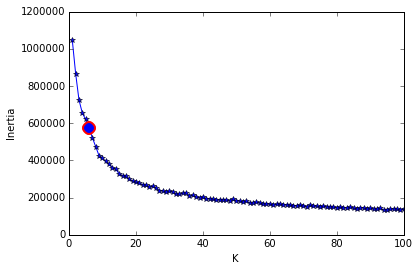

In [45]:
for k in ks:
    #kmeans = KMeans(k).fit(X)
    kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', n_init=1, init_size=1000, batch_size=1000).fit(X)
    inertias[k - 1] = kmeans.inertia_
    # first difference    
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    # second difference
    if k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    # third difference
    if k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

elbow = np.argmin(diff3[3:]) + 3
print elbow

plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

** We plotted the inertias for different values of K from 1 to 100. Using the approach of calculating the third differential to find an elbow point, the elbow point happens here for K=6 or 7 and is marked with a red dot **

In [58]:
from pandas.tools.plotting import scatter_matrix
X = np.loadtxt(os.path.join(MODEL_DIR, "train_jobs_lsi_coords.csv"), delimiter="\t")
df = pd.DataFrame(X, columns=range(10))

In [90]:
NUM_TOPICS = 5

X = np.loadtxt(os.path.join(MODEL_DIR, "train_jobs_lsi_coords.csv"), delimiter="\t")
kmeans = MiniBatchKMeans(n_clusters=NUM_TOPICS, init='k-means++', n_init=1, init_size=1000, batch_size=1000).fit(X)
y = kmeans.labels_

colors = [ "peru", "dodgerblue", "brown", "darkslategray", "lightsalmon", "orange", "springgreen", "orangered", "yellow", "firebrick" ]

In [78]:
Counter(y)

Counter({0: 3994, 1: 107, 2: 1968, 3: 197, 4: 3734})

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff05eefa690>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff056513a90>]], dtype=object)

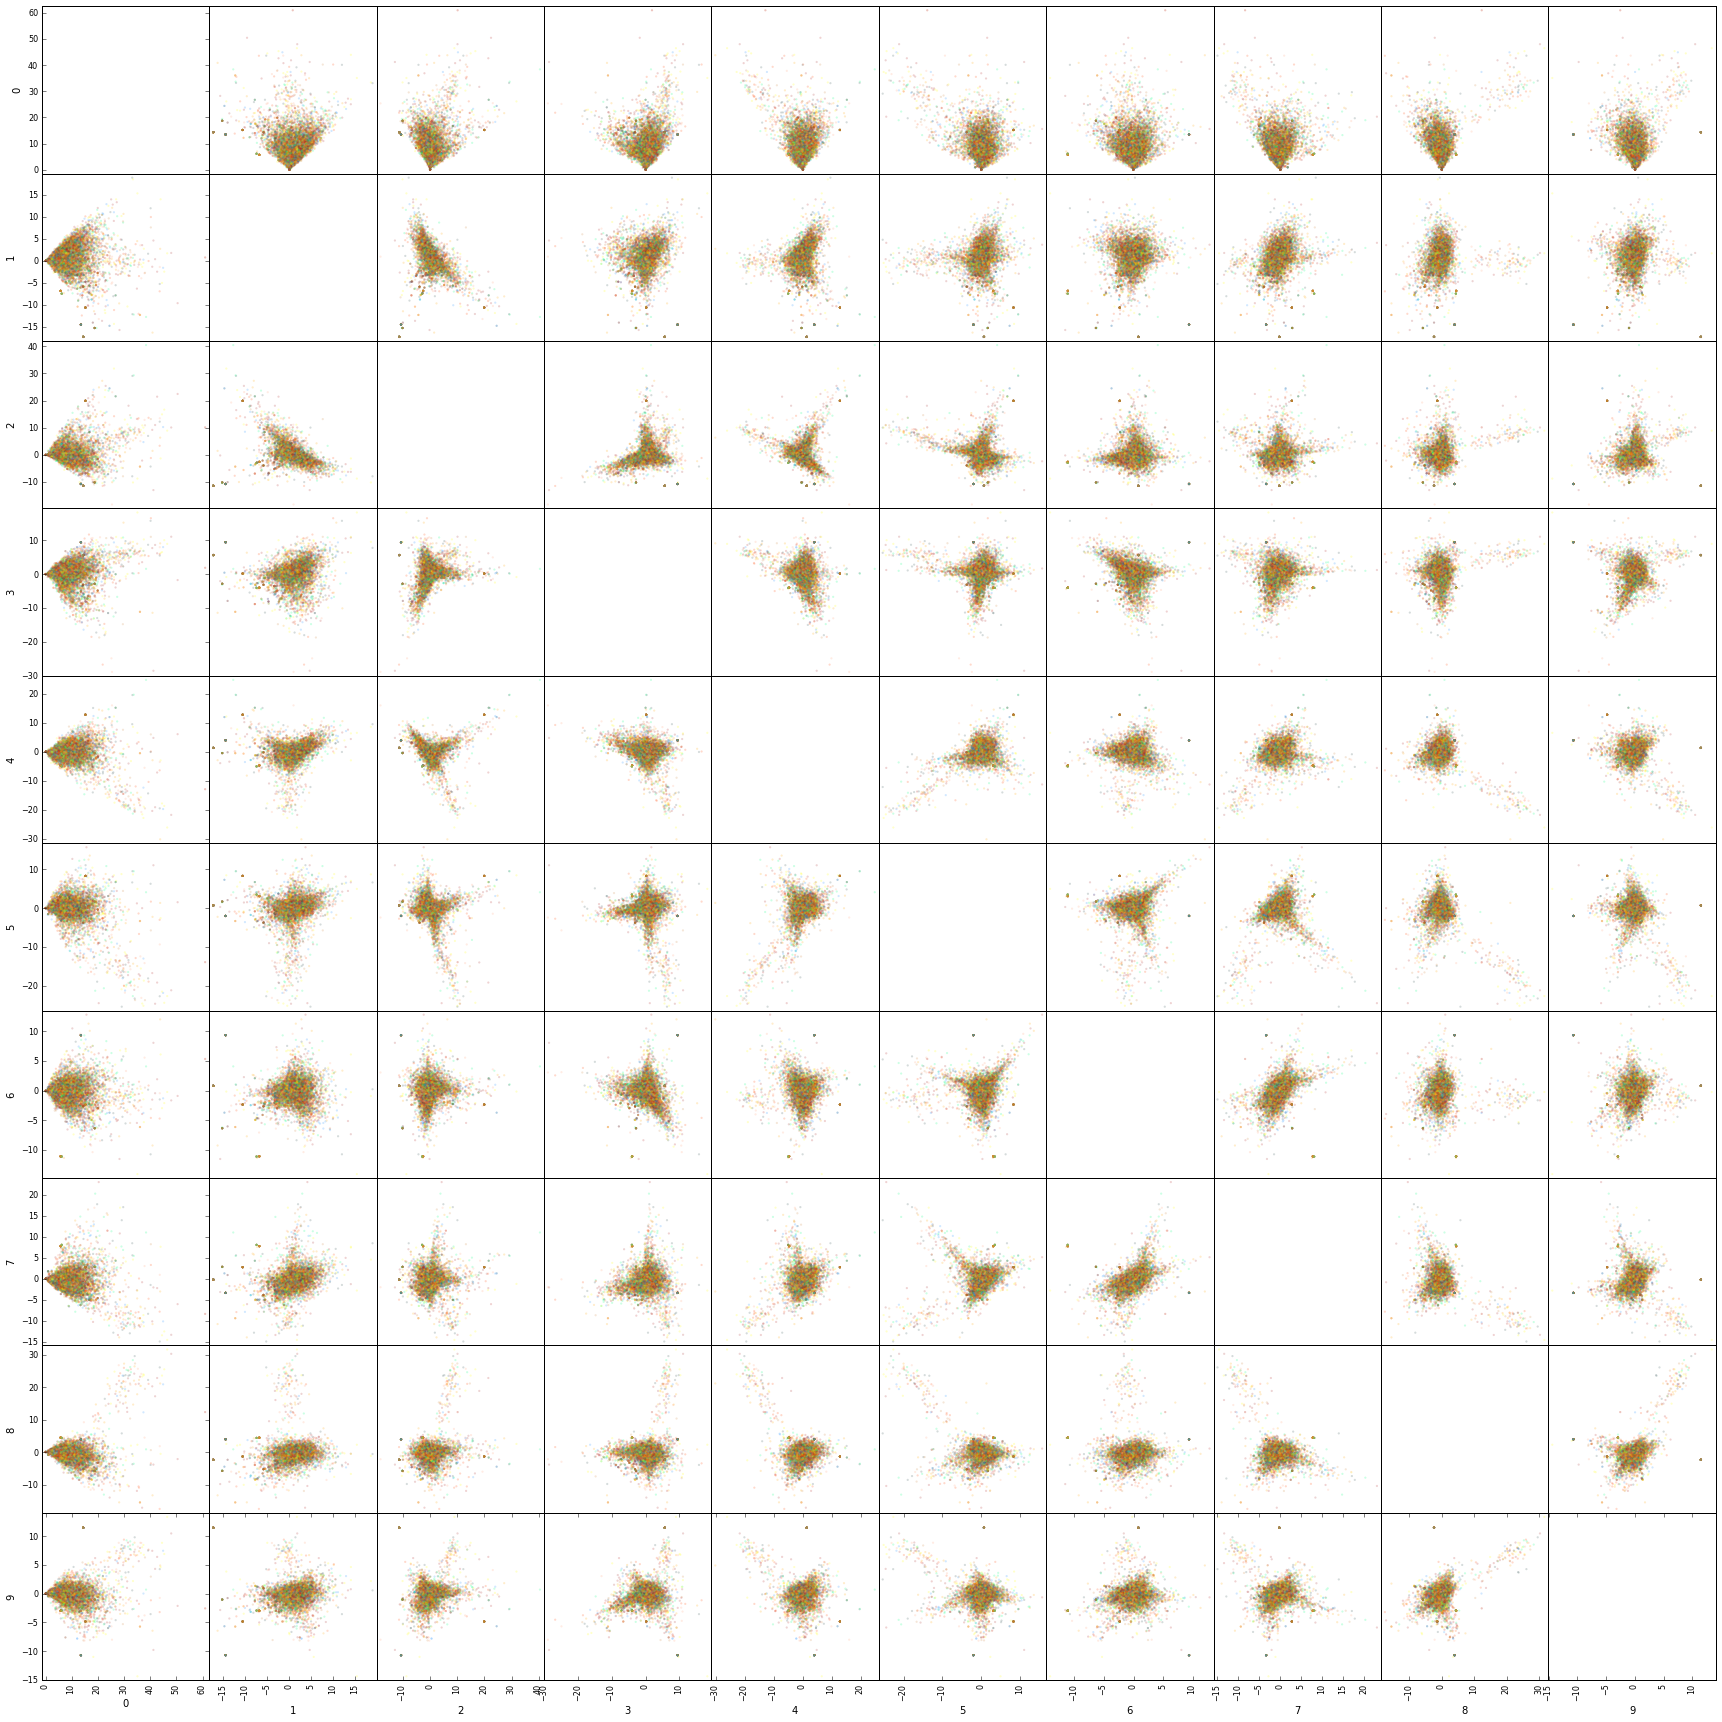

In [92]:
#Plotting 

df = pd.DataFrame(X, columns=range(10))
scatter_matrix(df, figsize=(50,50), alpha=0.2, marker='.', c=colors, diagonal=None, edgecolors='None')

#for j in range(10):
#    for k in range(10):
#        if j < k:
#            plt.figure(figsize=(10,10))
#            plt.title("Scatter plot for ({}, {})".format(j, k))
#            for i in range(X.shape[0]):
#                plt.scatter(X[i][j], X[i][k], c=colors[y[i]], s=10)
#            plt.show()

## 7. Topic Modeling using LDA

In [52]:
%%time
dictionary = corpora.Dictionary.load(os.path.join(MODEL_DIR, "train_jobs.dict"))
corpus = corpora.MmCorpus(os.path.join(MODEL_DIR, "train_jobs.mm"))

# Project to LDA space
NUM_TOPICS = 7
lda = gensim.models.LdaModel(corpus, id2word=dictionary, num_topics=NUM_TOPICS, 
                             chunksize=2000, 
                             passes=20, 
                             alpha='auto',
                             eval_every=10,
                             minimum_probability=0.01
                            )

CPU times: user 26min 55s, sys: 3.91 s, total: 26min 59s
Wall time: 27min 16s


### Topic Terms

In [53]:
lda.print_topics(NUM_TOPICS, 50)[0]

(0,
 u'0.020*experience + 0.014*data + 0.011*systems + 0.010*management + 0.010*support + 0.009*technical + 0.009*project + 0.009*business + 0.007*skills + 0.007*knowledge + 0.007*years + 0.007*requirements + 0.006*software + 0.006*system + 0.006*work + 0.006*security + 0.006*information + 0.006*development + 0.006*required + 0.006*analysis + 0.005*design + 0.005*ability + 0.005*related + 0.004*team + 0.004*solutions + 0.004*technology + 0.004*projects + 0.004*engineering + 0.004*degree + 0.004*processes + 0.004*including + 0.004*provide + 0.004*working + 0.003*process + 0.003*testing + 0.003*applications + 0.003*issues + 0.003*test + 0.003*services + 0.003*strong + 0.003*job + 0.003*application + 0.003*network + 0.003*analyst + 0.003*tools + 0.003*environment + 0.003*must + 0.003*quality + 0.003*complex + 0.003*database')

In [54]:
ftopics = open(os.path.join(MODEL_DIR, "train_jobs_topics.txt"), 'wb')
for t in lda.print_topics(NUM_TOPICS, 50):
    ftopics.write(str(t[0]) + ':' + t[1] + '\n')
ftopics.close()

### Job Topics

In [55]:
fjobtopics = open(os.path.join(MODEL_DIR, "train_jobs_topics.csv"), 'wb')
for doc_id in range(len(corpus)):
    docbow = corpus[doc_id]
    doc_topics = lda.get_document_topics(docbow)
    for topic_id, topic_prob in doc_topics:
        fjobtopics.write("%d\t%d\t%.3f\n" % (doc_id, topic_id, topic_prob))
fjobtopics.close()

### Topic wordcloud representation for analysis

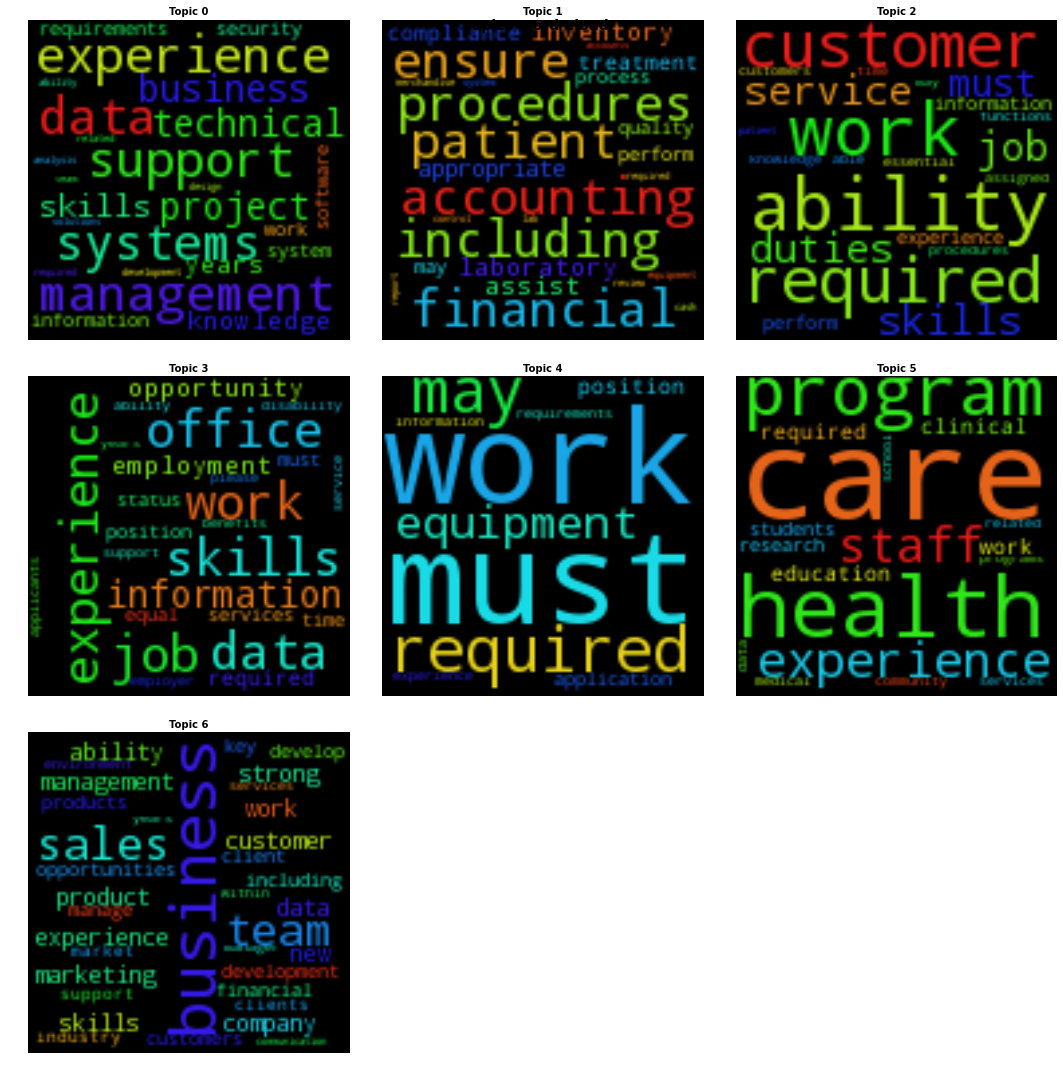

In [65]:
final_topics = open(os.path.join(MODEL_DIR, "train_jobs_topics.txt"), 'rb')
number_of_subplots=NUM_TOPICS
v = 0
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(top = 0.85)

for line in final_topics:
    line = line.strip('\n')
    curr_topic = line.split(':')[0]
    topic_scores = ''.join(line.split(':')[1:])

    scores = [float(x.split("*")[0]) for x in topic_scores.split(" + ")]
    words = [x.split("*")[1] for x in topic_scores.split(" + ")]

    freqs = []
    for word, score in zip(words, scores):
        freqs.append((word, score))

    elements = WordCloud(width=120, height=120).fit_words(freqs)
    
    v += 1
    ax1 = fig.add_subplot(int(NUM_TOPICS/3)+1, 3, v)
    ax1.set_title("Topic {}".format(curr_topic), fontsize=10, fontweight='bold')
    ax1.imshow(elements)
    ax1.axis("off")

fig.suptitle("Topics Word Cloud", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
final_topics.close()

### Topic Probability Distribution for Given List of jobs

In [57]:
NUM_TOPICS = 7

In [58]:
topic_df = pd.read_csv(os.path.join(MODEL_DIR, "train_jobs_topics.csv"), sep="\t", 
                   names=["doc_id", "topic_id", "topic_prob"], 
                   skiprows=0)

#doc_ids = []
#for i in range(6):
#    doc_ids.append(int(random.random() * max_doc_id))

def plot_job_distr(df, search_job_ids, train_labels):
    job_idx = [ x[0] for x in train_labels ]

    for job_id in search_job_ids:
        index = job_idx.index(job_id)
        filt = df[df["doc_id"] == index]
        topic_ids = filt["topic_id"].tolist()
        topic_probs = filt["topic_prob"].tolist()
        prob_dict = dict(zip(topic_ids, topic_probs))

        ys = []
        for i in range(NUM_TOPICS):
            if prob_dict.has_key(i):
                ys.append(prob_dict[i])
            else:
                ys.append(0.0)

        plt.title("Job ID: {}; Title: {}".format(train_labels[index][2], train_labels[index][0]))
        plt.ylabel("P(topic)")
        plt.ylim(0.0, 1.0)
        plt.xticks(range(NUM_TOPICS), ["Topic#%d" % (x) for x in range(NUM_TOPICS)])
        plt.grid(True)
        plt.bar(range(NUM_TOPICS), ys, align="center")
        plt.show()

In [91]:
topic_df.head()

,doc_id,topic_id,topic_prob
0,0,1,0.351
1,0,2,0.086
2,0,3,0.074
3,0,4,0.150
4,0,5,0.337


In [59]:
search_job_ids = [
    'indeed_93afb59a4354e71c', 
    'indeed_cfa9c10b65a3be0d', 
    'indeed_68f91473438121e2'
]

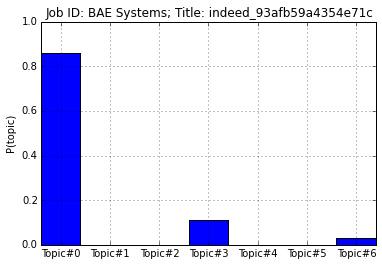

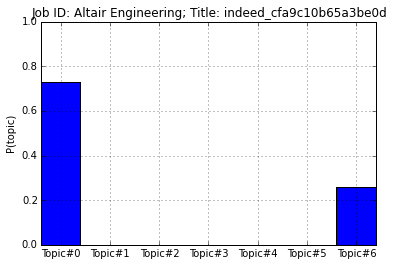

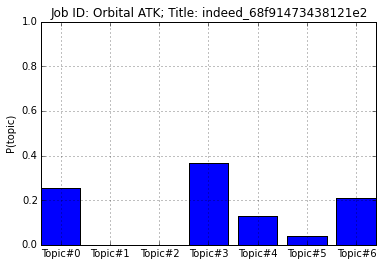

In [60]:
plot_job_distr(topic_df, search_job_ids, train_labels)

### Topic wise distribution
** Particular job can be tagged in multiple topics. We will assign topic # to a job based on top score **

In [61]:
topic_idx = topic_df.groupby(['doc_id'])['topic_prob'].transform(max) == topic_df['topic_prob']
top_topics = topic_df[topic_idx]
top_topics.groupby(['topic_id'])['topic_id'].agg(['count'])

,count
topic_id,
0,2175
1,324
2,1832
3,1646
4,636
5,1331
6,2067


In [102]:
topic_docs = [ train_labels[x] for x in top_topics[top_topics['topic_id'] == 5]['doc_id'] ]
topic_docs_df = pd.DataFrame.from_records(topic_docs, 
                                columns=["Job Id", "Job Title", "Company"])
topic_docs_df

,Job Id,Job Title,Company
0,indeed_53c5e81c18aa4202,Project Coordinator/Data Analyst,"The Fund for Public Health in New York, Inc."
1,indeed_3550996c6c6a4cab,ABA Therapist - SE Houston,Unlocking The Spectrum
2,indeed_3cabcc318228ceab,SUBSTITUTE: ABA Therapist/PCA,"Early Autism Project, Inc."
3,indeed_edb90543eb022346,Department Business Administrator,University of Houston
4,indeed_74136ac954c1da4a,Sales and Marketing / Clinical Liaison / Hospice,ACUITY PROFESSIONAL PLACEMENT SOLUTIONS
5,indeed_40f3f2a5d50f550f,Administrative Assistant -Office of Campus Life,Curry College
6,indeed_1d30fbfb4053839b,Senior Associate Dean for Finance and Administ...,VA Commonwealth Univ
7,indeed_574a6d74f4fd98ca,Area Manager,Fresenius Medical Care
8,indeed_f9aa330d6be55993,Clinical Manager,UIS Technologies Inc
9,indeed_ef811c95a31a6629,Senior Policy Analyst,ADMIN FOR CHILDREN'S SVCS


## 8. Testing with Random Job Post

In [94]:
!tail -1 ~/wrk/jobs/data/export_jobs_w_title.txt | awk -F'|' '{print $5}' > ~/wrk/jobs/data/test.txt
!tail -1 ~/wrk/jobs/data/export_jobs_w_title.txt | awk -F'|' '{print $1"|"$2"|"$3"|"$4}' > ~/wrk/jobs/data/test_labels.txt
!cat ~/wrk/jobs/data/test.txt
!cat ~/wrk/jobs/data/test_labels.txt

McCoyâs Building Supply is looking for a strong candidate for a new  Pricing Analyst position based at our Headquarters facility in San Marcos, Texas. This is an exempt-level position, and the final salary for this position is to be determined.     Our ideal  Pricing Analyst candidate will be responsible for driving price optimization and executing pricing strategies at McCoyâs.  This includes gathering competitor pricing, developing pricing scenarios that fit each categoryâs overall strategy, and supporting your recommendations to McCoyâs Merchants, with maximizing profitable market share growth for the business as the main goal. You need to be collaborative and persuasive, have a technical eye, and be able to communicate with non-technical teammates. Fact based, data driven decision-making is a key part of what youâll do to deliver the best pricing plans to our Merchandising and Operations Teams, and ultimately to our Born to Build Customers.      SOME OF THE DUTIES AND RES

In [99]:
!grep indeed_50bf5026f812b820 ~/wrk/jobs/data/export_jobs_w_title.txt | awk -F'|' '{print $5}' > ~/wrk/jobs/data/test.txt
!grep indeed_50bf5026f812b820 ~/wrk/jobs/data/export_jobs_w_title.txt | awk -F'|' '{print $1"|"$2"|"$3"|"$4}' > ~/wrk/jobs/data/test_labels.txt
!cat ~/wrk/jobs/data/test.txt
!cat ~/wrk/jobs/data/test_labels.txt

Teachers hold primary responsibility for the implementation and development of Uncommonâs curriculum and the success of its students. Therefore, Uncommon Schools seeks teachers who are committed to continuously improving curriculum and instruction through collaboration as part of a grade level team. Implement curricula and activities to meet academic standards;Design and implement assessments that measure progress towards academic standards;Use assessment data to refine curriculum and inform ins o-o-o 
indeed_50bf5026f812b820|High School Algebra 1 Teacher (2016-2017 School Year)|Preparatory Charter Schools|http://www.indeed.com/viewjob?jk=50bf5026f812b820&qd=PuuFZTQAvQAUoZwXvwwydVJX_fBthdM8Fvcy9hVLgMsm1Jstv5h9RbSRH07keVMyhGW0PtQg12oEkmVRFhi1RJifobd018Nm_bbbb0NA9MI&indpubnum=3869750015307590&atk=1abet3edfbqnj8lk


In [100]:
# compile sample documents into a list
test_set = [ preprocess(line.decode('unicode_escape').encode('ascii', 'ignore')) for line in open('/home/rt/wrk/jobs/data/test.txt', 'r') ]

# list for tokenized documents in loop
test_tokenized = tokenize_only(test_set[0])
test_dict = corpora.Dictionary([test_tokenized])
test_bow = dictionary.doc2bow(test_tokenized)

** Let's see what topis test document belongs to **

In [101]:
for topics in lda[test_bow]:
    print topics

(5, 0.98190453974814329)


** So the test document belongs to topics 0, 2, 3, 7 and 9 **

In [58]:
print test_set

[u"Now Hiring Company Truck Drivers. At Transport America We Raised Pay!  Company Truck Driver Benefits: Top 10% Industry Pay Year Round Steady Freight Performance Pay   Experienced Drivers Earn Top Scale in 2 Years Flexible Home Time, Including Get Home Certificates 24 7 Support, 365 Days A Year Pick Your Schedule Option Lease Purchase Options Day 1 Medical Dental Vision Disability Benefits Package Transfer Opportunities Available E Logs and an InCab Communication Hub Roll Stability and OnGuard System CSA Safe Carrier New Fleet of Equipment  New Kenworths In Delivery  At Transport America, our goal is to deliver excellence in all that we do. At a time when others are moving to asset lite models, we are committed to running assets in networks, which gives you reliable capacity with an excellence of service unsurpassed in the transportation industry. We are big enough to create meaningful solutions, but small enough to provide you the level of customer service you deserve. We believe in

***

## Appendix

### 1. Tokenizing and Stemming

In [209]:
vocab_stemmed = []
vocab_tokenized = []

for jobdesc in train:
    stemmed = tokenize_and_stem(jobdesc) 
    vocab_stemmed.extend(stemmed)
    
    tokenized = tokenize_only(jobdesc)
    vocab_tokenized.extend(tokenized)

337 337
337


In [210]:
print "{}, {}".format(len(vocab_stemmed), len(vocab_tokenized))

337, 337


In [211]:
df_vocab = pd.DataFrame({'words': vocab_tokenized}, index = vocab_stemmed)
df_vocab = df_vocab.drop_duplicates()
print 'there are ' + str(df_vocab.shape[0]) + ' items in vocab_frame'

there are 235 items in vocab_frame


In [212]:
print df_vocab.head(20)

               words
potbelli    potbelly
associ    associates
job              job
make            make
custom     customers
realli        really
happi          happy
sinc           since
primari      primary
point          point
custom      customer
contact      contact
provid       provide
excel      excellent
experi    experience
provid     providing
fast            fast
friend      friendly
effici     efficient
servic       service
